In [23]:
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import VGAE, GCNConv
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt

In [24]:
# load alanine dipeptide trajectory 
molecule = md.load_pdb("../simulation/single.pdb")

## Visulization of Single molecule

In [25]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
show_ase(water)

NGLWidget()

## Extracting Node Features from each atom of molecule

In [26]:
# Relative position of atoms on one molecule
poitions = molecule.xyz[0]
com = poitions.mean(axis=0)

relative_pos = poitions-com

# atomic Number
atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass 
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T


print("Relative positions:\n",relative_pos)
print("\natomic_numbers:\n",atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n",mass)

Relative positions:
 [[-0.01795 -0.03465 -0.008  ]
 [ 0.07775 -0.03465 -0.008  ]
 [-0.04185  0.05795 -0.008  ]
 [-0.01795  0.01135  0.024  ]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [27]:
node_features = np.concatenate((relative_pos,atomic_nums,vdwr,mass),axis=1)
print("Node Features:\n",node_features)

Node Features:
 [[-1.79500002e-02 -3.46500017e-02 -8.00000038e-03  8.00000000e+00
   1.52000000e-01  1.59994300e+01]
 [ 7.77500048e-02 -3.46500017e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-4.18500006e-02  5.79500012e-02 -8.00000038e-03  1.00000000e+00
   1.20000000e-01  1.00794700e+00]
 [-1.79500002e-02  1.13499984e-02  2.40000002e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


## Creating a Graph from the molecule

In [28]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
  from_list.append(edge.atom1.index)
  to_list.append(edge.atom2.index)
  from_list.append(edge.atom2.index)
  to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [29]:
graph = data.Data(x=torch.from_numpy(node_features),edge_index=torch.from_numpy(edge_list))

In [30]:
print(graph)

Data(x=[4, 6], edge_index=[2, 4])


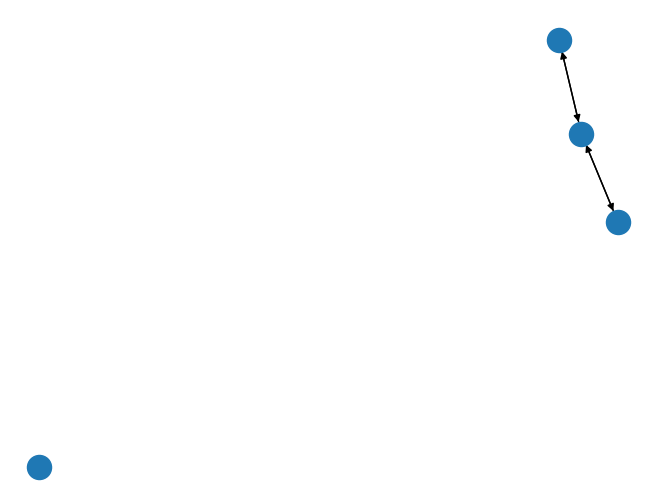

In [31]:
vis = to_networkx(graph)
nx.draw(vis)

In [32]:
graphs = [graph for _ in range(50)]

### **Encoder Part** 

#### **Input**
A Graph $G$ with $n$ nodes and $m$ edges. Features of each node $x_i$ cosisits of Relative positions of atoms, atomic numbers, Vander wall Radii and atomic mass.

#### **Architecture**
```
(encoder): VariationalGCNEncoder(
    (conv1): GCNConv(6, 12)
    (conv2): GCNConv(12, 6)
    (pool): SAGPooling(GraphConv, 6, ratio=0.5, multiplier=1.0)
    (conv_mu): GCNConv(6, 3)
    (conv_logstd): GCNConv(6, 3)
  )
```
<!-- align center -->
<center><img src="../../assets/moleculeGAAN.svg" style="margin:auto;"/></center>

#### **Output**
A latent vector $z$ of size $3$ for each node.





In [33]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 4 * out_channels)
        self.conv2 = GCNConv(4*out_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv_mu(x, edge_index).relu(), self.conv_logstd(x, edge_index).relu()


In [34]:
in_channels = graph.num_features
out_channels = 3
lr = 1e-2
n_epochs = 20
batch_size=2

model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [35]:
train_loader = DataLoader(graphs, batch_size=batch_size)

## Training Processes

In [36]:
def train():
    model.train()
    model.double()
    loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all +=  float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [37]:
Losses = []
for epoch in range(1, n_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    Losses.append(loss)


Epoch: 001, Loss: 3.9607
Epoch: 002, Loss: 0.9185
Epoch: 003, Loss: 0.9984
Epoch: 004, Loss: 0.9297
Epoch: 005, Loss: 1.0010
Epoch: 006, Loss: 0.9273
Epoch: 007, Loss: 1.0823
Epoch: 008, Loss: 1.0390
Epoch: 009, Loss: 0.8681
Epoch: 010, Loss: 0.9146
Epoch: 011, Loss: 1.0732
Epoch: 012, Loss: 1.0443
Epoch: 013, Loss: 1.0859
Epoch: 014, Loss: 1.0523
Epoch: 015, Loss: 0.9693
Epoch: 016, Loss: 1.0196
Epoch: 017, Loss: 0.9995
Epoch: 018, Loss: 0.9391
Epoch: 019, Loss: 0.9001
Epoch: 020, Loss: 0.9453


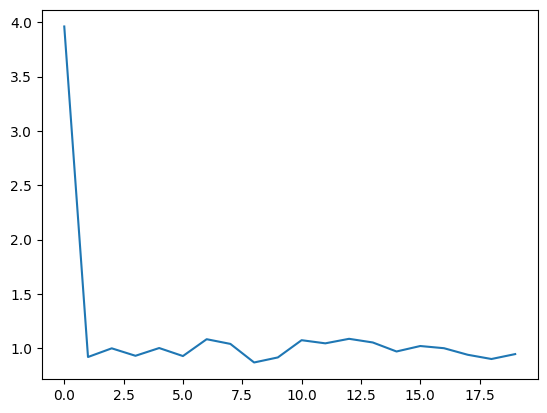

In [38]:
plt.plot(Losses)

## Inferencing Processes

In [45]:
model.double()
z = model.encode(graph.x, graph.edge_index)
r = model.decoder.forward_all(z)

print("Input Graph: \n", graph.x)
print("\nEncoded Graph: \n",z)
print("\nDecoded ADJ Matrix: \n",r)

Input Graph: 
 tensor([[-1.7950e-02, -3.4650e-02, -8.0000e-03,  8.0000e+00,  1.5200e-01,
          1.5999e+01],
        [ 7.7750e-02, -3.4650e-02, -8.0000e-03,  1.0000e+00,  1.2000e-01,
          1.0079e+00],
        [-4.1850e-02,  5.7950e-02, -8.0000e-03,  1.0000e+00,  1.2000e-01,
          1.0079e+00],
        [-1.7950e-02,  1.1350e-02,  2.4000e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00]], dtype=torch.float64)

Encoded Graph: 
 tensor([[-0.1773,  2.4143, -1.2608],
        [-0.1064,  2.2771, -0.5397],
        [-0.3913,  0.3511,  0.6118],
        [-0.2654,  0.1818,  0.3727]], dtype=torch.float64,
       grad_fn=<AddBackward0>)

Decoded ADJ Matrix: 
 tensor([[0.9994, 0.9980, 0.5363, 0.5040],
        [0.9980, 0.9959, 0.6250, 0.5600],
        [0.5363, 0.6250, 0.6572, 0.5977],
        [0.5040, 0.5600, 0.5977, 0.5603]], dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)


## Graph Reconstruction

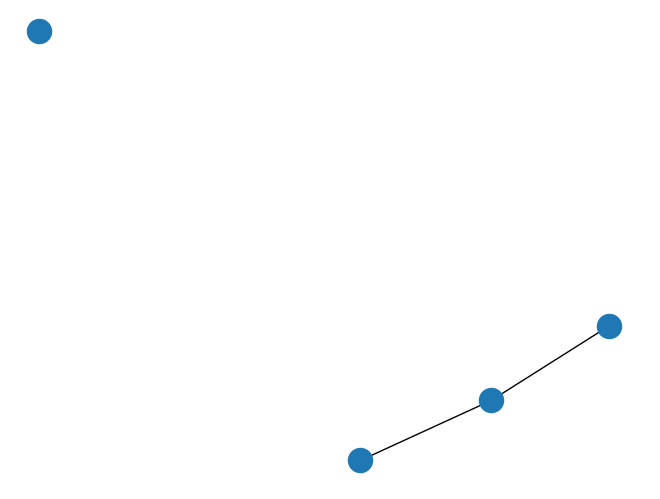

In [48]:
add_self_loops=False
adj_binary = r > 0.6
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
G.add_node(4)
nx.draw(G)
plt.show()
